In [9]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend, incrementalDrift
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler    
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV

In [10]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

sgd_onehot_1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder='passthrough')

sgd_onehot_2 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder='passthrough')


onehot4 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1]
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)
hybrid_model2 = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

hybrid_xgb_pipe2 = Pipeline([
    ('preprocessor', onehot4),
    ('regressor', hybrid_model2)
])


sgd_pipe = Pipeline([
    ('preprocessor', sgd_onehot_2),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor())
])


sgd_pipe_online = Pipeline([
    ('preprocessor', sgd_onehot_1),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor())
])

switcher = [hybrid_xgb_pipe, sgd_pipe_online]

In [3]:
def full_run():
    products = []
    customers = []
    for i in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[hybrid_xgb_pipe2, switcher], algorithm_name=["Gradient boosting", "Model switching"], LearningModes=["Offline", "Hybrid"])
    return thesis


In [4]:
thesis = full_run() 

Finished experiment! Elapsed time: 0.37378406524658203, total Elapsed time: 0.37378406524658203, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.47372865676879883, total Elapsed time: 0.8475127220153809, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.4717280864715576, total Elapsed time: 1.3192408084869385, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.21287775039672852, total Elapsed time: 1.532118558883667, Algorithm: Gradient boosting Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finished experiment! Elapsed time: 0.21387600898742676, t

In [6]:
results = thesis.resultsToDF()

In [7]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                         mean   
Algorithm         Drift type        Drift time     Drift magnitude              
Gradient boosting Incremental Drift Fully observed Large             6.380833   
                                                   Small             3.402500   
                                    Half observed  Large            11.395000   
                                                   Small             3.397500   
                                    Unobserved     Large            11.952500   
                                                   Small             3.555833   
                  No Drift          No Drift       No Drift          2.727500   
                  Sudden Drift      Fully observed Large             6.020000   
                                                   Small             3.349167   
                                    Half observed  Large             5.474167   
                                                   Small             2.940000   
                                    Unobserved     Large            14.395833   
                                                   Small             3.891667   
                  Sudden Shock      3 days         Large             3.537500   
                                                   Small             2.905000   
                                    7 days         Large             3.040000   
                                                   Small             2.842500   
Model switching   Incremental Drift Fully observed Large             6.380833   
                                                   Small             3.402500   
                                    Half observed  Large             6.488333   
                                                   Small             3.116667   
                                    Unobserved     Large             5.398333   
                                                   Small             3.228333   
                  No Drift          No Drift       No Drift          2.727500   
                  Sudden Drift      Fully observed Large             6.020000   
                                                   Small             3.349167   
                                    Half observed  Large             5.474167   
                                                   Small             2.940000   
                                    Unobserved     Large             6.312500   
                                                   Small             3.489167   
                  Sudden Shock      3 days         Large             3.537500   
                                                   Small             2.905000   
                                    7 days         Large             3.040000   
                                                   Small             2.842500   

                                                                              \
                                                                         std   
Algorithm         Drift type        Drift time     Drift magnitude             
Gradient boosting Incremental Drift Fully observed Large            2.084765   
                                                   Small            0.590672   
                                    Half observed  Large            5.845810   
                                                   Small            0.947668   
                                    Unobserved     Large            6.582242   
                                                   Small            0.958763   
                  No Drift          No Drift       No Drift         0.043493   
                  Sudden Drift      Fully observed Large            2.024909   
                                                   Small            0.644240   
                                    Half observed  Large            1.292443   
                                  

In [8]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,MSE,SMAPE
216,Switcher,0.0,Sudden Drift,Large,Important,Unobserved,2141.143423,30.27
257,Switcher,3.0,Sudden Drift,Large,Important,Unobserved,2109.324766,29.81
52,LR,0.0,Sudden Drift,Large,Important,Unobserved,2065.635284,29.67
134,LR,6.0,Sudden Drift,Large,Important,Unobserved,2068.642374,29.56
298,Switcher,6.0,Sudden Drift,Large,Important,Unobserved,2063.530495,29.50
...,...,...,...,...,...,...,...,...
200,Switcher,NaN,No Drift,No Drift,No Drift,No Drift,16.065908,2.55
323,Switcher,6.0,No Drift,No Drift,No Drift,No Drift,15.463177,2.54
311,Switcher,6.0,Incremental Drift,Small,Unimportant,Fully observed,15.711803,2.53
293,Switcher,6.0,Sudden Drift,Small,Unimportant,Fully observed,15.798491,2.53


Next up is changepoint/drift detection!
Let's start with doing it on a single series and then ramp up complexity to multivariate cases

In [40]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

In [41]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10)
#generateTrend(test_prod, indices=1, magnitude=3)
suddenDrift(test_prod, variables=0, magnitude=3, time=140)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float)

In [42]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index)


In [43]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.9)

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [44]:
changepoint

[BOCPDChangePoint(start_time: 2017-05-20T00:00:00.000000000, end_time: 2017-05-20T00:00:00.000000000, confidence: 0.9789737411774339, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-05-21T00:00:00.000000000, end_time: 2017-05-21T00:00:00.000000000, confidence: 0.9799999940954781, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response)]

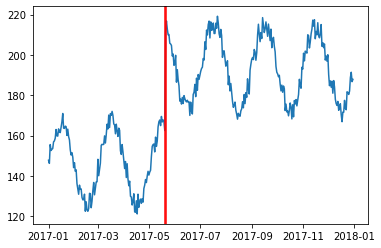

In [45]:
det.plot(changepoint);

In [46]:
test_prod.iloc[[110]]

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-04-21,25.576258,26.605038,2.111045,15.707047,21.914527,23.963883,24.406188,10.019339,30.431647,24.41993,128.512764,2017.0,16.0,5.0
